In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from tifffile import tifffile
from matplotlib import pyplot as plt
from PIL import Image
from skimage.measure import label
from skimage.color import label2rgb
import cv2

from skimage.exposure import rescale_intensity
from skimage.segmentation import clear_border

from mnfinder import MNModel

/Volumes/T7/new_NN/test-data/.laptop/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Loading a model and generating a prediction
Several different neural net predictors are available:

In [3]:
MNModel.get_available_models()

['Combined',
 'SimpleCombined',
 'Attention',
 'Attention96',
 'MSAttention',
 'MSAttention96',
 'LaplaceDeconstruction']

Let’s try the `Attention` model, which is the default.

In [6]:
attention_model = MNModel.get_model('Attention')

Testing and training data are stored in the package and can be accessed via the `MNModel.testing_root` and `MNModel.testing_root` paths.

The following image is of live U2 OS cells expressing H2B-emiRFP703 and NLS-3xDendra2, taken on a 20x widefield microscope.

In [7]:
img = tifffile.imread(MNModel.testing_root / "images/4.tif")
img.shape

(2, 768, 869)

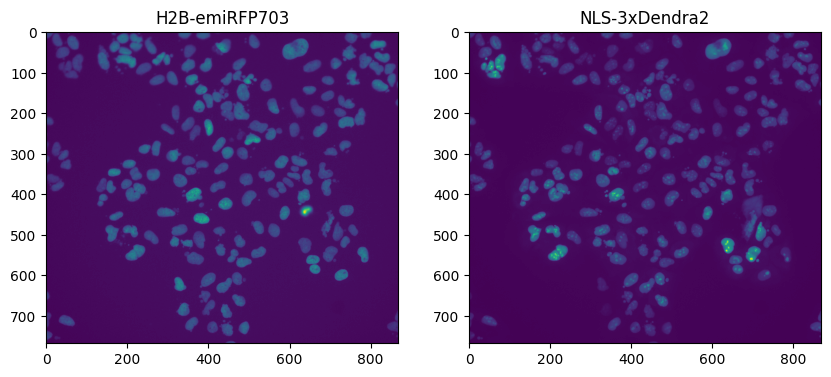

In [9]:
f,ax = plt.subplots(1,2, figsize=(10,14))
ax[0].set_title("H2B-emiRFP703")
ax[0].imshow(img[0])
ax[1].set_title("NLS-3xDendra2")
ax[1].imshow(img[1])

In [10]:
# Generate a prediction
nuc_labels, mn_labels, mn_raw = attention_model.predict(img[0])

## Prediction vs ground truth

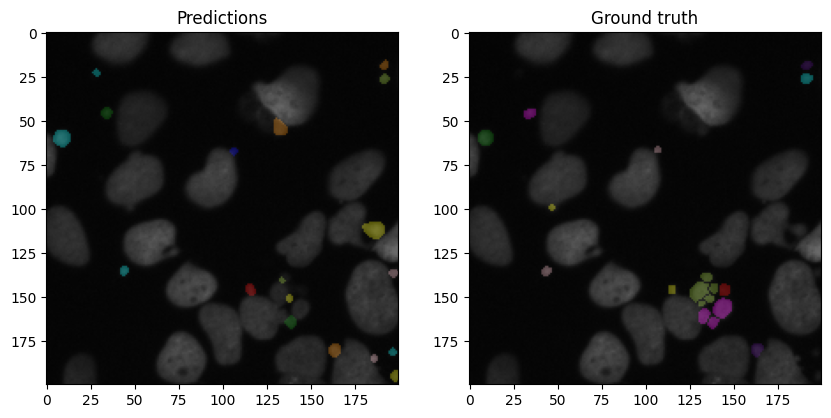

In [11]:
# Load ground truth
true_labels = np.array(Image.open(MNModel.testing_root / "mn_masks/4.png"))
true_labels = label((true_labels[...,0] > 0))

f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(img[0]))[0:200,300:500])
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(true_labels, rescale_intensity(img[0]))[0:200,300:500])

Direct comparison

IOU: 40.23%
Proportion predictions overlapping with true masks: 66.34%
Proportion predictions not overlapping with true masks: 33.66%


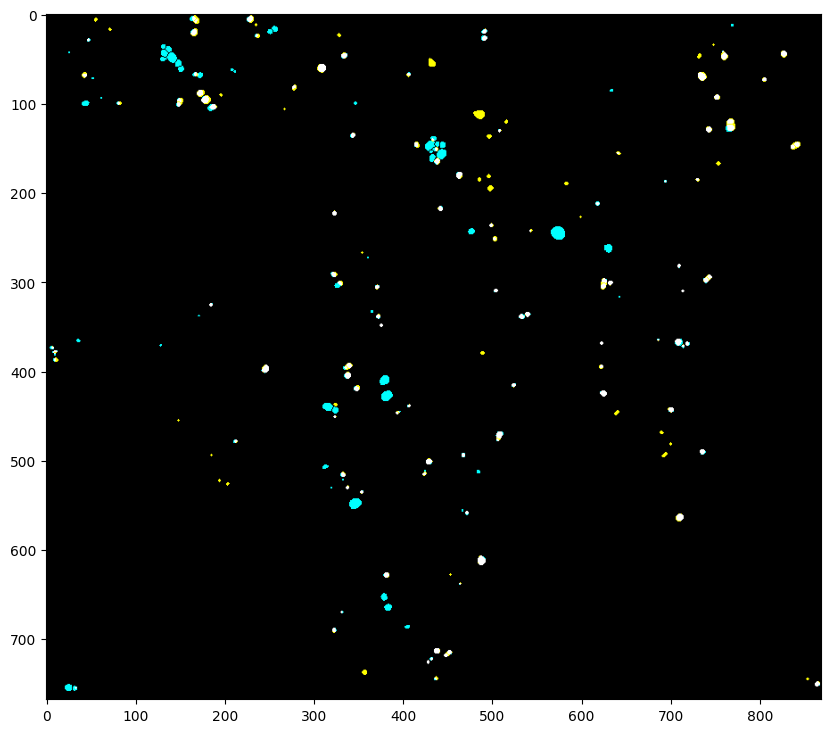

In [13]:
comparison = np.zeros(( img[0].shape[0], img[0].shape[1], 3), dtype=np.uint8)
comparison[(mn_labels > 0) & (true_labels <= 0)] = (255,255,0) # FP yellow
comparison[(mn_labels <= 0) & (true_labels > 0)] = (0,255,255) # FN blue
comparison[(mn_labels > 0) & (true_labels > 0)] = (255,255,255) # TP

f,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(comparison)
intersection = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0) | (true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

## Adjusting prediction parameters
MNFinder uses some post-processing to increase prediction accuracy, including binary opening and mask expansion. These steps can be skipped, if you wish.

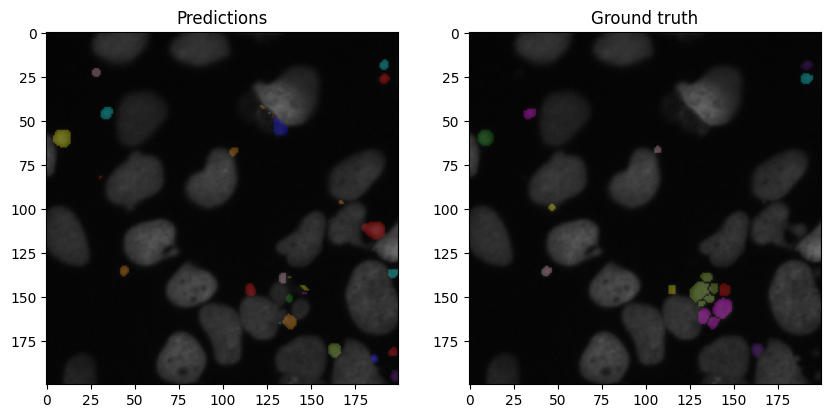

In [15]:
nuc_labels, mn_labels, mn_raw = attention_model.predict(img[0], skip_opening=True)

f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(img[0]))[0:200,300:500])
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(true_labels, rescale_intensity(img[0]))[0:200,300:500])

IOU: 10.30%
Proportion predictions overlapping with true masks: 71.73%
Proportion predictions not overlapping with true masks: 28.27%


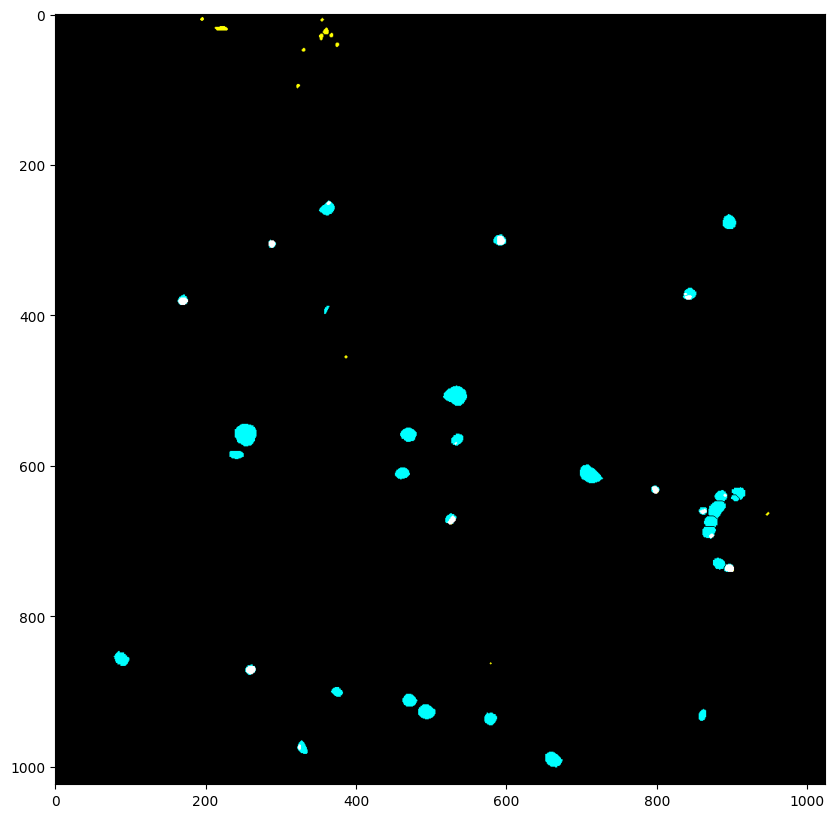

In [24]:
comparison = np.zeros(( img[0].shape[0], img[0].shape[1], 3), dtype=np.uint8)
comparison[(mn_labels > 0) & (true_labels <= 0)] = (255,255,0) # FP yellow
comparison[(mn_labels <= 0) & (true_labels > 0)] = (0,255,255) # FN blue
comparison[(mn_labels > 0) & (true_labels > 0)] = (255,255,255) # TP

f,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(comparison)
intersection = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0) | (true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

## Images at higher resolutions
Models were trained on images taken on a 20x objective. Images taken at other resolutions should be rescaled for optimal results.

This image is of fixed RPE-1 cells expressing 2xRFP-NLS and stained with DAPI, taken on a 40x confocal objective.

In [18]:
img = tifffile.imread(MNModel.testing_root / "images/MAX_2022-12-29 ATF3 tilescan.lif - BAY.tif")
img.shape

(2, 1024, 1024)

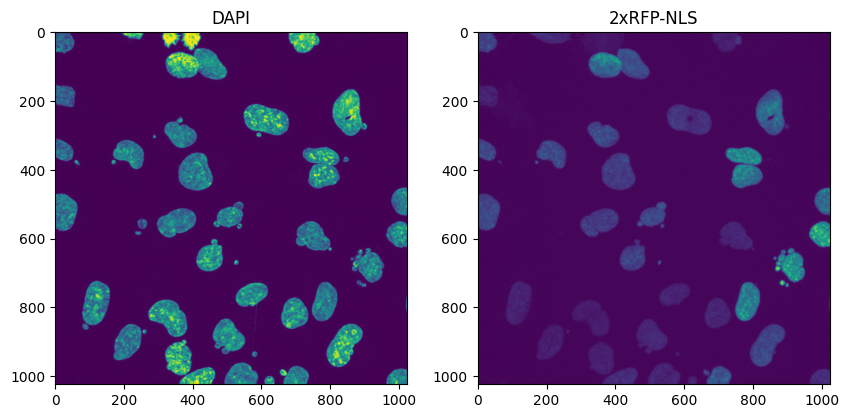

In [19]:
f,ax = plt.subplots(1,2, figsize=(10,14))
ax[0].set_title("DAPI")
ax[0].imshow(img[0])
ax[1].set_title("2xRFP-NLS")
ax[1].imshow(img[1])

In [21]:
# Load ground truth
true_labels = np.array(Image.open(MNModel.testing_root / "mn_masks/MAX_2022-12-29 ATF3 tilescan.lif - BAY.png"))
true_labels = label((true_labels[...,0] > 0))

IOU: 10.30%
Proportion predictions overlapping with true masks: 71.73%
Proportion predictions not overlapping with true masks: 28.27%


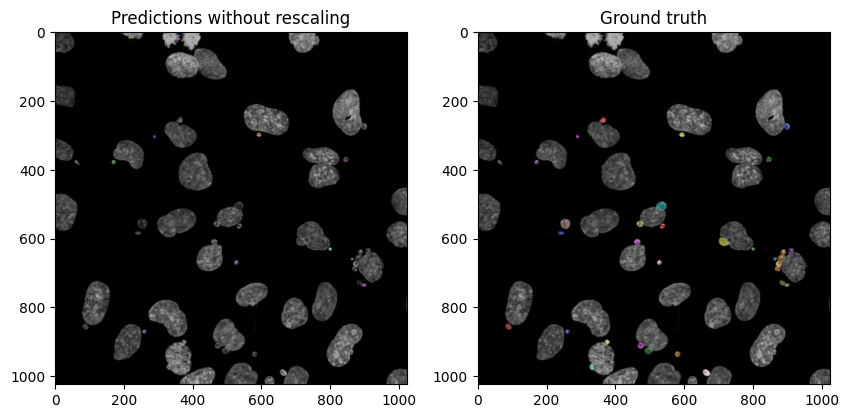

In [25]:
nuc_labels, mn_labels, mn_raw = attention_model.predict(img[0])

f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions without rescaling")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(img[0])))
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(true_labels, rescale_intensity(img[0])))

intersection = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0) | (true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

IOU: 49.19%
Proportion predictions overlapping with true masks: 84.98%
Proportion predictions not overlapping with true masks: 15.02%


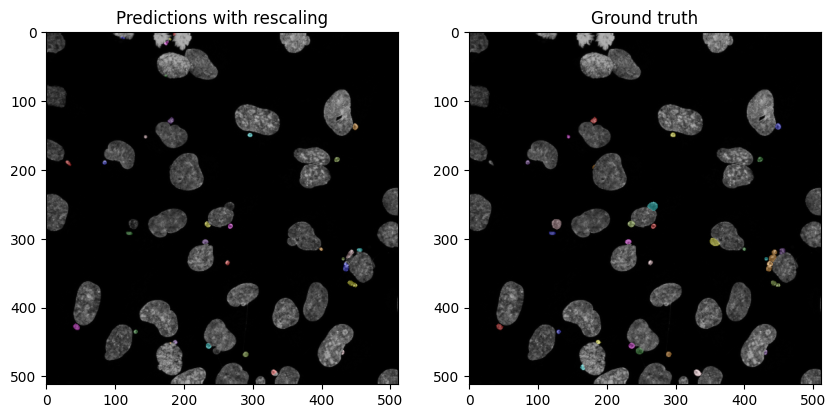

In [27]:
# Resize the image
resized_img = cv2.resize(img[0], None, fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
resized_true_labels = cv2.resize(true_labels, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)

nuc_labels, mn_labels, mn_raw = attention_model.predict(resized_img)
f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions with rescaling")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(resized_img)))
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(resized_true_labels, rescale_intensity(resized_img)))

intersection = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (resized_true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0) | (resized_true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

mIOU: 49.19%
Proportion predictions overlapping with true masks: 84.98%
Proportion predictions not overlapping with true masks: 15.02%


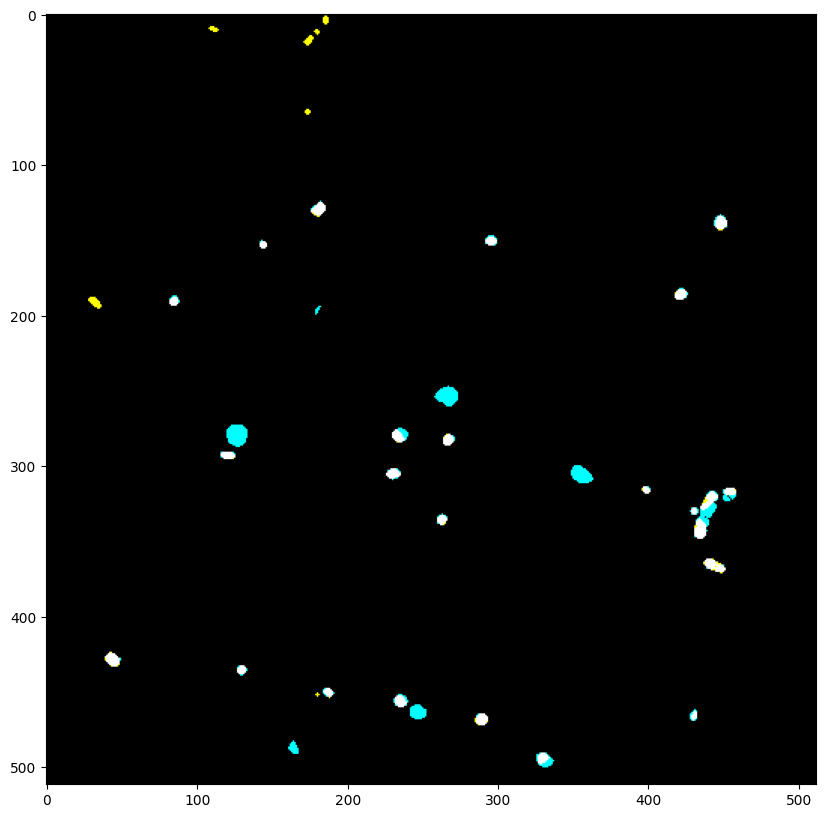

In [28]:
comparison = np.zeros(( resized_img.shape[0], resized_img.shape[1], 3), dtype=np.uint8)
comparison[(mn_labels > 0) & (resized_true_labels <= 0)] = (255,255,0) # FP yellow
comparison[(mn_labels <= 0) & (resized_true_labels > 0)] = (0,255,255) # FN blue
comparison[(mn_labels > 0) & (resized_true_labels > 0)] = (255,255,255) # TP

f,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(comparison)
intersection = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (resized_true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0) | (resized_true_labels > 0))
print("mIOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

## Retraining models
You may find training on your data set improves predictions for your use cases.

New training data should be structured as follows:
````
path/to/training-data/
    data-set1/
        images/
            img1.tiff
            ...
        mn_masks/
            img1.png
            ...
        nucleus_masks/
            img1.png
            ...
    data-set2/
        images/
            different-img.TIF
        mn_masks/
            different-img.png
        nucleus_masks/
            different-img.png
````

Validation data should be structured similarly.

Micronucleus and nucleus masks should have non-zero values wherever there is a micronucleus or nucleus, respectively. If you wish to distinguish between ruptured and intact micronuclei during model evaluation, intact micronuclei should have pixels = `1` and ruptured micronuclei = `2`.    

If no alternative path is provided, the new weights will replace the weights that come with this package.

In [ ]:
m, history = attention_model.train(
    train_path=MNModel.training_root, 
    val_path=MNModel.training_root, 
    save_weights=False,
    epochs=1
)

In [49]:
df = history.history.copy()
df['epoch'] = history.epoch
df = pd.DataFrame(df)
df

,loss,sigmoid_focal_crossentropy_loss,sigmoid_focal_crossentropy,mean_iou,mean_iou_with_nuc,accuracy,val_loss,val_sigmoid_focal_crossentropy_loss,val_sigmoid_focal_crossentropy,val_mean_iou,val_mean_iou_with_nuc,val_accuracy,lr,epoch
0,0.069302,0.069302,0.069302,0.029405,0.165866,0.904672,0.052629,0.052629,0.052629,0.04606,0.263545,0.899729,0.0005,0


In [61]:
new_attention_model = MNModel.get_model('Attention', trained_model=m)

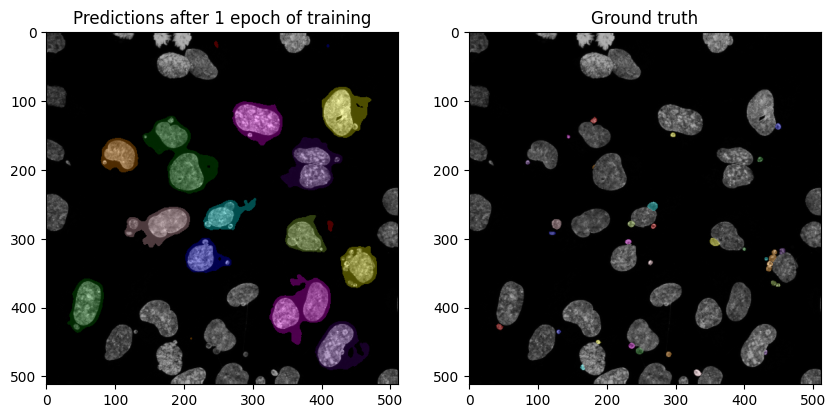

In [66]:
new_nuc_labels, new_mn_labels, new_mn_raw = new_attention_model.predict(resized_img, expand_masks=False)
f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions after 1 epoch of training")
ax[0].imshow(label2rgb(new_mn_labels, rescale_intensity(resized_img)))
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(resized_true_labels, rescale_intensity(resized_img)))

## Evaluating predictions
MNFinder can evaluate predictions based on ground truth masks

In [29]:
true_mask = np.array(Image.open(MNModel.testing_root / "mn_masks/MAX_2022-12-29 ATF3 tilescan.lif - BAY.png"))
resized_true_mask = cv2.resize(true_mask, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)

# The mask is a PNG stored as RGBA, to make it easy to view in Photoshop
# Let's convert it to a simple 2D numpy array where pixels == 1 micronuclei

# It's possible to distinguish between intact and ruptured micronuclei
# by setting ruptured micronuclei == 2
mn_true_mask = np.zeros(( resized_true_mask.shape[0], resized_true_mask.shape[1] ), dtype=np.uint8)
mn_true_mask[(resized_true_mask[...,0] > 0)] = 1
if resized_true_mask.shape[2] == 4:
  mn_true_mask[(resized_true_mask[...,3] == 0)] = 0

mn_true_mask = clear_border(mn_true_mask)
mn_df, pred_df, summary_df = MNModel.eval_mn_prediction(mn_true_mask, mn_labels)

### Micronucleus information
**`true_mn_label`**
: The unique ID of this micronucleus

**`intact`**
: If this micronucleus is intact; will always be true if not distinction was made between ruptured and intact micronuclei in the true mask

**`found`**
: If at least one pixel overlaps with a prediction

**`area`**
: The area of the micronucleus in pixels

**`proportion_segmented`**
: The proportion of this micronucleus that overlaps with one or more predictions

**`pred_labels`**
: The ID(s) of the prediction that overlaps with this micronucleus

In [30]:
mn_df

,true_mn_label,intact,found,area,proportion_segmented,pred_labels
0,1,True,True,65,0.938462,[6]
1,2,True,True,69,0.840580,[7]
2,3,True,True,47,0.765957,[8]
3,4,True,True,23,0.913043,[9]
4,5,True,True,53,0.886792,[10]
5,6,True,True,38,0.789474,[12]
6,7,True,False,12,0.000000,[]
7,8,True,False,149,0.000000,[]
8,9,True,False,170,0.000000,[]
9,10,True,True,81,0.629630,[13]


### Prediction information
**`true_mn_label`**
: The unique ID of this prediction

**`exists`**
: If at least one pixel overlaps with a true micronucleus

**`area`**
: The area of the prediction in pixels

**`proportion_true`**
: The proportion of this prediction that overlaps with one or more micronuclei

**`true_labels`**
: The ID(s) of the micronucleus that overlaps with this prediction

In [31]:
pred_df

,pred_mn_label,exists,area,proportion_true,true_labels
0,1,False,20,0.000000,[]
1,2,False,18,0.000000,[]
2,3,False,10,0.000000,[]
3,4,False,28,0.000000,[]
4,5,False,12,0.000000,[]
5,6,True,65,0.938462,[1]
6,7,True,61,0.950820,[2]
7,8,True,36,1.000000,[3]
8,9,True,21,1.000000,[4]
9,10,True,48,0.979167,[5]


### Summary statistics
**`num_mn`**
: The number of micronuclei in this field

**`num_intact_mn`/`num_ruptured_mn`**
: The number of intact and ruptured micronuclei in this field (if any distinction was made)

**`num_predictions`**
: The number of predictions

**`num_mn_found`/`num_intact_mn_found`/`num_ruptured_mn_found`**
: The number of micronuclei that overlap with a prediction

**`iou`**
: IoU describes the intersection of micronucleus and prediction pixels / the union of the same

**`intersection`**
: The number of pixels that overlap between micronuclei and predictions

**`divergence`**
: The number of prediction pixels that do not overlap with true micronuclei

**`ppv`**
: The proportion of predictions that overlap with true micronuclei

**`recall`/`intact_recall`/`ruptured_recall`**
: The proportion of micronuclei that overlap with predictions

In [32]:
summary_df

,num_mn,num_intact_mn,num_ruptured_mn,num_predictions,num_mn_found,num_intact_mn_found,num_ruptured_mn_found,iou,intersection,divergence,ppv,recall,intact_recall,ruptured_recall
0,29,29,0,31,23,23,0,0.491909,1064,188,0.741935,0.793103,0.793103,NaN


(0.0, 1.2)

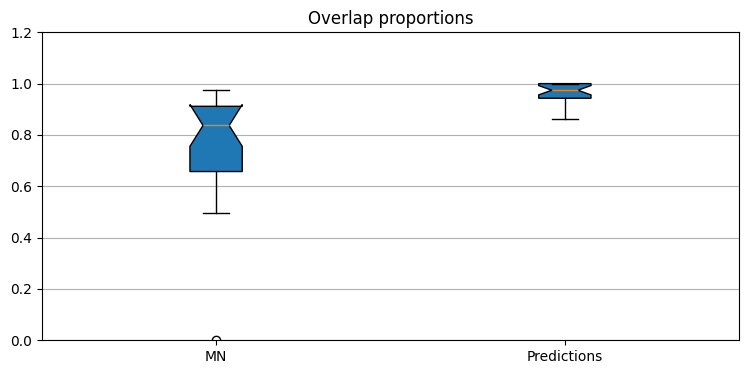

In [33]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

# Equalize number of prediction and true segment arrays
found_mn = mn_df['proportion_segmented'].loc[mn_df['found']]
true_pred = pred_df['proportion_true'].loc[pred_df['exists']]
longest = np.max([ len(found_mn), len(true_pred) ])
mn_pad = longest-len(found_mn)
pred_pad = longest-len(true_pred)
all_data = [ 
    np.pad(found_mn, (0,mn_pad), 'empty'), 
    np.pad(true_pred, (0,pred_pad), 'empty')
]

bplot2 = ax.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['MN','Predictions'])  # will be used to label x-ticks
ax.set_title('Overlap proportions')
ax.yaxis.grid(True)
ax.set_ylim(0,1.2)